# Protein EBM for analysing dynamics

In [1]:
import torch

In [2]:
saved = torch.load("/paperspace/apps/ProteinEBM/dynamics/chignolin_dynamics_20251212_103049/dynamics_trajectory.pt")

In [3]:
print(saved.keys())

dict_keys(['all_pos', 'all_t0', 'args', 'all_scoring_energies', 'native_energy', 'num_resample_rounds', 'cluster_resampling_firstround', 'cluster_resampling_allrounds'])


In [4]:
diffs = [i for i,x in enumerate(saved['all_pos']) if x.shape[0] != saved['all_pos'][0].shape[0]]
start = min(diffs) if len(diffs) > 0 else 0

nbatch = len(saved['all_pos'][start:])
print(nbatch)

all_pos = torch.stack([x for x in saved['all_pos']][start:]).reshape((nbatch,1) + saved['all_pos'][-1].shape) 
all_t0 = torch.stack([x for x in saved['all_t0']][start:]).reshape((nbatch,1) + saved['all_t0'][-1].shape) 
all_nrgs = torch.stack([x[0] for x in saved['all_scoring_energies']][start:]).view(-1)

1


In [11]:
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import is_aa
from protein_ebm.data.protein_utils import residues_to_features, plot_protein_frame
from protein_ebm.model.boltz_utils import center_random_augmentation

#Load the structure
parser = PDBParser(QUIET=True)
structure = parser.get_structure("my_structure","/paperspace/apps/ProteinEBM/eval_data/fastfolders/experimental_structures/chignolin_cln025.pdb")

chain = [c for c in structure.get_chains()][0]
atom_positions, atom_mask, aatype, residue_idx = residues_to_features([r for r in chain.get_residues() if is_aa(r)])
nres = atom_positions.shape[0]

residue_mask = torch.ones(nres) 
aatype = torch.tensor(aatype, dtype=torch.long)
ca_coords = center_random_augmentation(atom_positions[...,1,:].unsqueeze(0), torch.ones([1, nres])).view([1,-1,3])


/paperspace/apps/ProteinEBM/protein_ebm/data/protein_utils.py:143: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  atom_positions = torch.tensor(atom_positions, dtype=torch.float32)
/tmp/ipykernel_564662/2568870276.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aatype = torch.tensor(aatype, dtype=torch.long)


In [12]:
plot_protein_frame(atom_positions, atom_mask, cartoon=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [13]:
import numpy as np

def np_rmsd(true, pred):
  def sigmoid(z):
    return 1/(1 + np.exp(-z))
  
  def kabsch(P, Q):
    V, S, W = np.linalg.svd(np.swapaxes(P, -1,-2) @ Q, full_matrices=False)
    flip = sigmoid(-10 * np.linalg.det(V) * np.linalg.det(W))
    S = flip[:,None] * np.concatenate([S[:-1], -S[-1:]]) + (1-flip)[:,None] * S
    V = flip[:, None, None] * np.concatenate([V[:,:-1], -V[:,-1:]], axis=1) + (1-flip)[:, None, None] * V
    return V@W
  p = true - true.mean(1,keepdims=True)
  q = pred - pred.mean(1,keepdims=True)
  p = p @ kabsch(p,q)
  loss = np.sqrt(np.square(p-q).sum(-1).mean(-1) + 1e-8)
  return loss

pred = all_t0.view((-1,) + all_t0.shape[4:])[...,1,:].numpy()
all_rmsd = np_rmsd(pred, ca_coords.numpy())

print("RMSD at lowest energy is", all_rmsd[np.argsort(all_nrgs)[0]])


RMSD at lowest energy is 0.8341516


Text(0, 0.5, 'Model Energy')

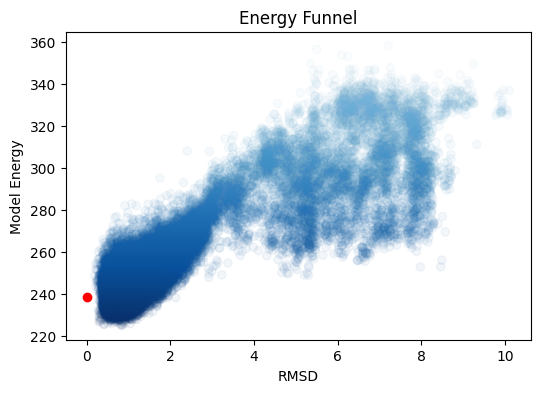

In [14]:
from matplotlib import colors
import matplotlib.pyplot as plt

native_energy = saved['native_energy']

def truncate_cmap(cmap, minval=0.0, maxval=1.0, n=256):
    """Return a truncated colormap from cmap between minval and maxval (fractions)."""
    cmap = plt.get_cmap(cmap)
    new_colors = cmap(np.linspace(minval, maxval, n))
    return colors.ListedColormap(new_colors)


plt.figure(figsize=(6, 4))
plt.scatter(all_rmsd, all_nrgs.numpy(), alpha=0.05, c=-all_nrgs.numpy(), cmap=truncate_cmap("Blues", minval=0.35))
plt.scatter(np.zeros(1), native_energy.numpy().mean(), color='red')
plt.title("Energy Funnel")
plt.xlabel("RMSD")
plt.ylabel("Model Energy")